In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# SHAP: NAICS hierarchy
Shapley comparisons for NAICS hierarchy model.  Look at importance of NAICS features

*This script takes about 10 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib

In [3]:
from pathlib import Path

In [4]:
import shap
import xgboost as xgb

## Data

In [5]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [6]:
train_df = sba_loans[sba_loans['dset'] == 'train']

## Models 
Load a bunch of models and create a dictionary.  Also get model-related data into dictionaries.

In [7]:
# Function to load the required information from models
def model_load(prefix = 'X01', path=setup.temp_path):
    model = xgb.Booster()
    model.load_model(Path(path).joinpath(prefix + '_MODEL_xgboost.json'))
    features_values = pd.read_parquet(Path(path).joinpath(prefix + '_DATA_encodings.parquet'))
    features_columns = [c for c in features_values.columns \
                        if c not in ['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']]
    with open(Path(path).joinpath(prefix + '_DATA_features_predict.pkl'), 'rb') as fin:
        features_predict = pickle.load(fin)
        
    return model, features_values, features_columns, features_predict

##### Models

In [8]:
# Standard target encoding of NAICS
xgb_model_menc, features_menc_values, features_menc_columns, features_predict_menc = \
    model_load('X04', setup.parent_path)

In [9]:
# Hierarchical target encoding by NAICS
xgb_model_mhier, features_mhier_values, features_mhier_columns, features_predict_mhier = \
    model_load('X10', setup.parent_path)

In [10]:
# Standard target encoding of all levels NAICS (separately)
xgb_model_menc_all, features_menc_all_values, features_menc_all_columns, features_predict_menc_all = \
    model_load('A22', setup.temp_path)

In [11]:
# Target+Count encoding, all levels NAICS
xgb_model_tc, features_tc_values, features_tc_columns, features_predict_tc = \
    model_load('A20', setup.temp_path)

In [12]:
# Target-Thresh encoding, all levels NAICS
xgb_model_tt, features_tt_values, features_tt_columns, features_predict_tt = \
    model_load('A21', setup.temp_path)

In [13]:
# Encoding column(s) into dictionary
feature_dict = {'menc': features_menc_columns, 
                'mhier':features_mhier_columns,
                'menc_all': features_menc_all_columns,
                'tc':features_tc_columns,
                 'tt':features_tt_columns}

In [14]:
# Encoded values into dictionary
feature_values_dict = {'menc': features_menc_values,
                       'mhier':features_mhier_values,
                       'menc_all': features_menc_all_values,
                       'tc':features_tc_values,
                       'tt':features_tt_values}

In [15]:
# Order for plots and tables, also print labels
feature_order = ['menc', 'mhier', 'menc_all', 'tc', 'tt']
num_models = len(feature_order)
print_dict = {'menc': 'Target encoding (NAICS only)', 
                'mhier':'Hierarchical Blending',
                'menc_all': 'Target encoding (NAICS hierarchy)',
                'tc':'Target+Count encoding',
                 'tt':'Target-Thresh encoding'}

In [16]:
# Models into a dictionary
model_dict = {'menc': xgb_model_menc, 
                'mhier':xgb_model_mhier,
                'menc_all': xgb_model_menc_all,
                'tc':xgb_model_tc,
                 'tt':xgb_model_tt}

In [17]:
# Predictor dictionary for compactness
predictor_dict = {'menc': features_predict_menc, 
                 'mhier':features_predict_mhier,
                'menc_all': features_predict_menc_all,
                'tc':features_predict_tc,
                 'tt':features_predict_tt}

In [18]:
predictor_dict.keys()

dict_keys(['menc', 'mhier', 'menc_all', 'tc', 'tt'])

## Datasets for Explanations
Wamt to use the same cases for all models.  Use the test holdout, and regular test data.  I need to append different features for each

In [69]:
# Function to get a dataset for a given modeal
def model_data(base_data, features_data, predictors_list):
    
    drop_cols = [c for c in features_data.columns if c != 'LoanNr_ChkDgt']
    data = base_data \
        .drop(columns = drop_cols, errors='ignore') \
        .merge(features_data,
               how='inner', on='LoanNr_ChkDgt')
    return data

##### Holdout data
Create data frames for all models

In [70]:
holdout_base = sba_loans[sba_loans['dset_naics_holdout'] == 1]

In [71]:
model_data_holdout_dict = {k: model_data(holdout_base, feature_values_dict[k],
                                 predictor_dict[k]) for k in feature_values_dict.keys()}

In [72]:
# Print the data shapes
{k:model_data_holdout_dict[k].shape for k in feature_values_dict.keys()}

{'menc': (65052, 58),
 'mhier': (65052, 58),
 'menc_all': (65052, 58),
 'tc': (65052, 68),
 'tt': (65052, 63)}

##### Random test data
Downsample a bit for speed.  Use the same data for all

In [73]:
sample_n = np.min([len(sba_loans['dset_naics_holdout'] == 0), 50000])
test_base = sba_loans[sba_loans['dset_naics_holdout'] == 0] \
    .sample(n=sample_n, random_state = 6)

In [74]:
model_data_test_dict = {k: model_data(test_base, feature_values_dict[k],
                                 predictor_dict[k]) for k in feature_values_dict.keys()}

In [75]:
# Print the data shapes
{k:model_data_test_dict[k].shape for k in feature_values_dict.keys()}

{'menc': (50000, 58),
 'mhier': (50000, 58),
 'menc_all': (50000, 58),
 'tc': (50000, 68),
 'tt': (50000, 63)}

## SHAP Explainers, Values
For the 3 models, generate explainers then explanations

##### Explainers

In [76]:
explainer_dict = {k: \
                  shap.TreeExplainer(model_dict[k], feature_names=predictor_dict[k]) \
              for k in predictor_dict.keys()}

In [77]:
explainer_dict

{'menc': <shap.explainers._tree.TreeExplainer at 0x301f2c460>,
 'mhier': <shap.explainers._tree.TreeExplainer at 0x302ddb670>,
 'menc_all': <shap.explainers._tree.TreeExplainer at 0x302e9a970>,
 'tc': <shap.explainers._tree.TreeExplainer at 0x301f24820>,
 'tt': <shap.explainers._tree.TreeExplainer at 0x302ddb3d0>}

##### Holdout values

In [78]:
shap_holdout_dict = {k: 
                     explainer_dict[k].shap_values(model_data_holdout_dict[k][predictor_dict[k]])
                     for k in predictor_dict.keys()}

##### Random test values

In [79]:
shap_test_dict = {k: 
                     explainer_dict[k].shap_values(model_data_test_dict[k][predictor_dict[k]])
                     for k in predictor_dict.keys()}

##### Save data

In [80]:
with open(Path(setup.temp_path).joinpath('A40_DATA_raw_shap_dict_ho.pkl'), 'wb') as fout:
    pickle.dump(shap_holdout_dict, fout)

In [81]:
with open(Path(setup.temp_path).joinpath('A40_DATA_raw_shap_dict_test.pkl'), 'wb') as fout:
    pickle.dump(shap_test_dict, fout)

##### Data frame convert and save

In [82]:
shap_holdout_df_dict = {k: pd.DataFrame(shap_holdout_dict[k], columns=predictor_dict[k],
                                       index = model_data_holdout_dict[k].index)
                        for k in predictor_dict.keys()}
with open(Path(setup.temp_path).joinpath('A40_DATA_df_shap_dict_ho.pkl'), 'wb') as fout:
    pickle.dump(shap_holdout_df_dict, fout)

In [83]:
shap_test_df_dict = {k: pd.DataFrame(shap_test_dict[k], columns=predictor_dict[k],
                                    index = model_data_test_dict[k].index)
                        for k in predictor_dict.keys()}
with open(Path(setup.temp_path).joinpath('A40_DATA_df_shap_dict_test.pkl'), 'wb') as fout:
    pickle.dump(shap_test_df_dict, fout)

## Long Format Data

In [84]:
# Function to convert SHAP data to a frame in long format
def get_shap_long(shap_df, features_encoded):
    
    long_df = shap_df.melt(ignore_index = False)
    
    long_df['enc_flag'] = np.where(long_df['variable'].isin(features_encoded), 1, 0)
    
    return long_df

In [85]:
# Apply the function to all models and concatenate
shap_all_long_test = pd.concat([get_shap_long(shap_test_df_dict[k],feature_dict[k]) \
                              .reset_index()
                         for k in predictor_dict.keys()],
                        keys=predictor_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'}) \
    .reset_index(drop=True)

In [86]:
shap_all_long_test.to_parquet(Path(setup.temp_path).joinpath('A40_DATA_shap_long_test.parquet'))

In [87]:
# Apply the function to all models and concatenate
shap_all_long_ho = pd.concat([get_shap_long(shap_holdout_df_dict[k],feature_dict[k]) \
                              .reset_index()
                         for k in predictor_dict.keys()],
                        keys=predictor_dict.keys()) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'model'}) \
    .reset_index(drop=True)

In [88]:
shap_all_long_ho.to_parquet(Path(setup.temp_path).joinpath('A40_DATA_shap_long_ho.parquet'))

In [89]:
shap_all_long_ho

,model,index,variable,value,enc_flag
0,menc,0,NoEmp,0.088689,0
1,menc,1,NoEmp,0.045408,0
2,menc,2,NoEmp,0.004393,0
3,menc,3,NoEmp,-0.049012,0
4,menc,4,NoEmp,0.049974,0
...,...,...,...,...,...
3707959,tt,65047,tt_NAICS_sector,-0.018786,1
3707960,tt,65048,tt_NAICS_sector,0.021960,1
3707961,tt,65049,tt_NAICS_sector,-0.018064,1
3707962,tt,65050,tt_NAICS_sector,-0.006799,1


## Encoding vs. Non-Encoding Features

In [90]:
def aggregate_by_enc_flag(data):
    data_1 = data \
        .groupby(['model', 'enc_flag', 'index']) \
        ['value'] \
        .agg('sum') \
        .reset_index(level=[0,1])
    data_1['value_abs'] = np.abs(data_1['value'])
    data_2 = data_1 \
        .groupby(['model', 'enc_flag']) \
        [['value_abs', 'value']] \
        .agg('mean') \
        .reset_index()
    return data_2

In [91]:
enc_flag_agg_test = aggregate_by_enc_flag(shap_all_long_test)
enc_flag_agg_test

,model,enc_flag,value_abs,value
0,menc,0,0.554551,-0.143952
1,menc,1,0.366625,-0.059871
2,menc_all,0,0.555496,-0.143553
3,menc_all,1,0.364793,-0.060546
4,mhier,0,0.548655,-0.142541
5,mhier,1,0.366027,-0.063126
6,tc,0,0.553378,-0.142560
7,tc,1,0.366186,-0.061357
8,tt,0,0.562067,-0.141959
9,tt,1,0.344905,-0.062151


In [92]:
enc_flag_agg_ho = aggregate_by_enc_flag(shap_all_long_ho)
enc_flag_agg_ho

,model,enc_flag,value_abs,value
0,menc,0,0.648219,-0.259119
1,menc,1,0.093835,0.093832
2,menc_all,0,0.640744,-0.255134
3,menc_all,1,0.088901,0.065283
4,mhier,0,0.612161,-0.231707
5,mhier,1,0.342198,-0.063008
6,tc,0,0.665498,-0.265534
7,tc,1,0.084458,0.028696
8,tt,0,0.693337,-0.209219
9,tt,1,0.192175,-0.159562


##### Plot

In [93]:
# Function to do bar plot
def shap_enc_flag_bar(data, values = 'value_abs',
                      title = None, xlabel = None, ax = None):
    
    # Label models
    data['model_label']  = setup.label_models(data)

    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
    data_pivot = data.pivot(index='model_label', columns='enc_flag', values=values) \
        .rename(columns={0:'other features', 1:'NAICS encoding feature(s)'})
    data_pivot .plot(kind='barh', ax=ax, width=0.7)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

In [94]:
setup.label_models(enc_flag_agg_test)

0    Target Encoding (NAICS only)
1    Target Encoding (NAICS only)
2           Target Encoding (all)
3           Target Encoding (all)
4           Hierarchical Blending
5           Hierarchical Blending
6           Target+Count Encoding
7           Target+Count Encoding
8          Target-Thresh Encoding
9          Target-Thresh Encoding
Name: model, dtype: category
Categories (5, object): ['Target Encoding (NAICS only)' < 'Hierarchical Blending' < 'Target Encoding (all)' < 'Target+Count Encoding' < 'Target-Thresh Encoding']

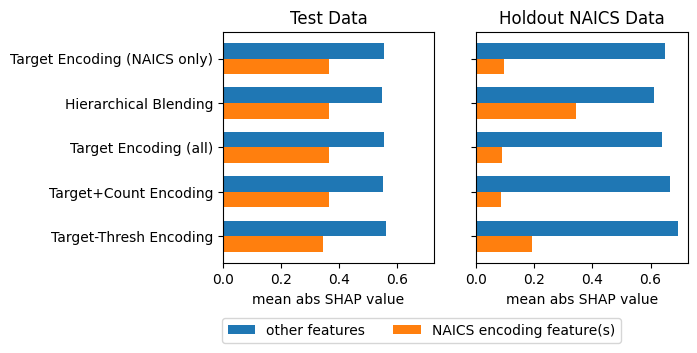

In [95]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 3))
shap_enc_flag_bar(enc_flag_agg_test, ax=ax[0], title='Test Data',
                     xlabel='mean abs SHAP value')
shap_enc_flag_bar(enc_flag_agg_ho, ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean abs SHAP value')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)
fig.savefig(Path(setup.temp_path).joinpath('A40_PLOT_enc_flag_mean_abs.png'),
        bbox_inches='tight')

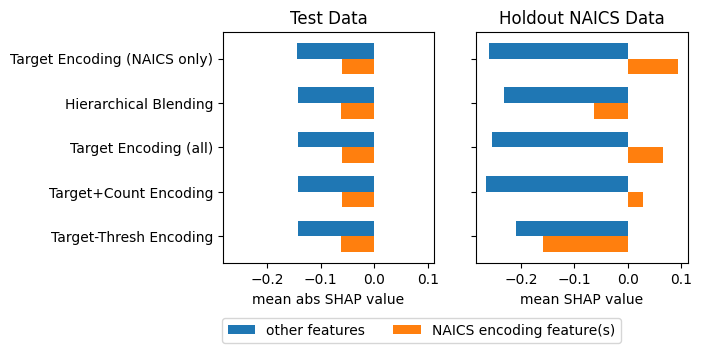

In [96]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 3))
shap_enc_flag_bar(enc_flag_agg_test, 'value', ax=ax[0], title='Test Data',
                     xlabel='mean abs SHAP value')
shap_enc_flag_bar(enc_flag_agg_ho, 'value', ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean SHAP value')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)
fig.savefig(Path(setup.temp_path).joinpath('A40_PLOT_enc_flag_mean_raw.png'),
        bbox_inches='tight')

In [97]:
enc_flag_agg_test.to_csv(Path(setup.temp_path).joinpath('A40_REPORT_importance_enc_flag_test.csv'))
enc_flag_agg_ho.to_csv(Path(setup.temp_path).joinpath('A40_REPORT_importance_enc_flag_ho.csv'))

## Detail Importances

##### Get mean abs shap, grouping non-encoding features into "other"
We only need this for the models with more than one encoding feature

In [98]:
def get_importances(long_df):
    agg_1 = long_df[long_df['enc_flag'] == 0] \
        .groupby(['model', 'index']) \
        .agg('sum') \
        .reset_index(level=0)
    agg_1['variable'] = 'other'
    agg_2 = pd.concat([agg_1,long_df[long_df['enc_flag'] == 1]])
    agg_2['value_abs'] = np.abs(agg_2['value'])
    
    imp_df = agg_2.groupby(['model', 'variable']) \
        ['value_abs'] \
        .agg('mean') \
        .reset_index()
    imp_df['model_label']  = setup.label_models(imp_df)
    return imp_df

In [99]:
import_all_disp= ['menc_all', 'tt', 'tc']

In [100]:
import_all_test = get_importances(shap_all_long_test)
import_all_test.to_csv(Path(setup.temp_path).joinpath('A40_REPORT_importance_detail_test.csv'))
import_all_test[import_all_test['model'].isin(import_all_disp)]

,model,variable,value_abs,model_label
2,menc_all,menc_NAICS,0.302684,Target Encoding (all)
3,menc_all,menc_NAICS_3,0.019705,Target Encoding (all)
4,menc_all,menc_NAICS_4,0.047046,Target Encoding (all)
5,menc_all,menc_NAICS_5,0.043018,Target Encoding (all)
6,menc_all,menc_NAICS_sector,0.015127,Target Encoding (all)
7,menc_all,other,0.555496,Target Encoding (all)
10,tc,NAICS_3_count,0.000000,Target+Count Encoding
11,tc,NAICS_3_response,0.021790,Target+Count Encoding
12,tc,NAICS_4_count,0.000000,Target+Count Encoding
13,tc,NAICS_4_response,0.038144,Target+Count Encoding


In [101]:
import_all_ho = get_importances(shap_all_long_ho)
import_all_ho.to_csv(Path(setup.temp_path).joinpath('A40_REPORT_importance_detail_ho.csv'))
import_all_ho[import_all_ho['model'].isin(import_all_disp)]

,model,variable,value_abs,model_label
2,menc_all,menc_NAICS,0.093559,Target Encoding (all)
3,menc_all,menc_NAICS_3,0.025926,Target Encoding (all)
4,menc_all,menc_NAICS_4,0.036070,Target Encoding (all)
5,menc_all,menc_NAICS_5,0.022228,Target Encoding (all)
6,menc_all,menc_NAICS_sector,0.014163,Target Encoding (all)
7,menc_all,other,0.640744,Target Encoding (all)
10,tc,NAICS_3_count,0.000000,Target+Count Encoding
11,tc,NAICS_3_response,0.029904,Target+Count Encoding
12,tc,NAICS_4_count,0.000000,Target+Count Encoding
13,tc,NAICS_4_response,0.029380,Target+Count Encoding


##### Plot

In [102]:
# Some data processing for bar plots
def shap_import_bar_preprocess(data, values = 'value_abs', n_bars=7):
    data= data.sort_values(values, ascending=False).head(n_bars).copy() \
        [['model_label', 'model', 'variable', values]]
    data['model_label'] = data['model_label'].astype('str')
    
    # Rename features
    if data['model'].iloc[0] in ['tt', 'menc_all']:
        data['variable'] = data['variable'].where(~data['variable'].str.contains('NAICS'),
                                              'NAICS' + data['variable'].str.split('NAICS').str[-1])
    elif data['model'].iloc[0] == 'tc':
                data['variable'] = data['variable'].where(~data['variable'].str.endswith('_response'),
                                              data['variable'].str.replace('_response', ''))
    return data

In [103]:
# Function to do bar plot for one model
def shap_import_bar(data, values = 'value_abs',
                      xlabel = None, ax = None,
                   n_bars=7):

    # Feature selection, renaming
    data = shap_import_bar_preprocess(data, values, n_bars)
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
        
    data.plot(x='variable', y=values, ax=ax, kind='barh', legend=None)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(data['model_label'].iloc[0])
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

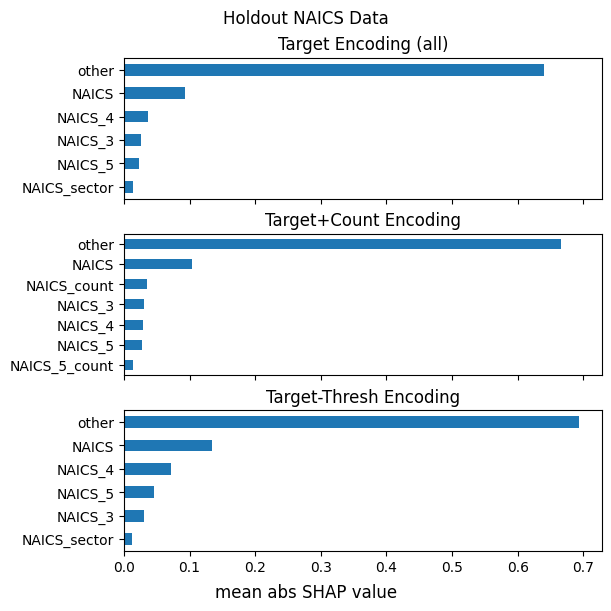

In [104]:
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
shap_import_bar(import_all_ho[import_all_ho['model'] == 'menc_all'], ax=ax[0])
shap_import_bar(import_all_ho[import_all_ho['model'] == 'tc'], ax=ax[1])
shap_import_bar(import_all_ho[import_all_ho['model'] == 'tt'], ax=ax[2])
fig.suptitle('Holdout NAICS Data')
fig.supxlabel('mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('A41_PLOT_importancs_holdout.png'))

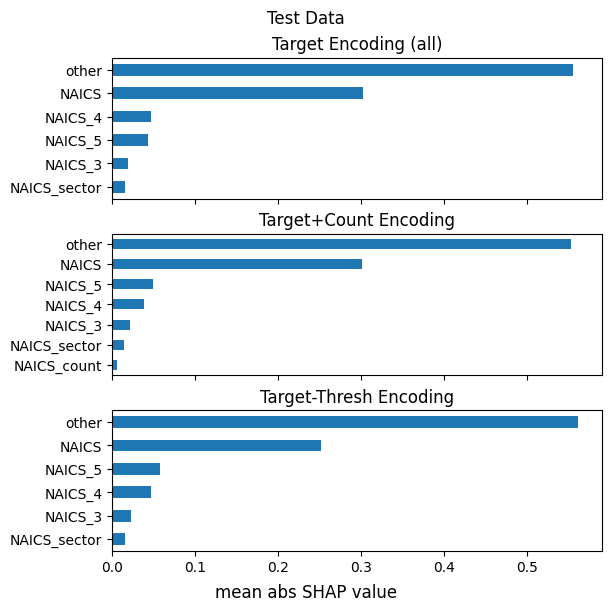

In [105]:
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
shap_import_bar(import_all_test[import_all_test['model'] == 'menc_all'], ax=ax[0])
shap_import_bar(import_all_test[import_all_test['model'] == 'tc'], ax=ax[1])
shap_import_bar(import_all_test[import_all_test['model'] == 'tt'], ax=ax[2])
fig.suptitle('Test Data')
fig.supxlabel('mean abs SHAP value')
fig.savefig(Path(setup.temp_path).joinpath('A41_PLOT_importancs_test.png'))

#### Single, bi-color plot

In [106]:
# Function to do bar plot for one model
def shap_import_bar_2color(data_test, data_holdout, values = 'value_abs',
                      xlabel = None, ax = None,
                   n_bars=7):

    data_test = shap_import_bar_preprocess(data_test, values, n_bars)
    data_holdout = shap_import_bar_preprocess(data_holdout, values, n_bars)
    
    data = pd.concat([data_test, data_holdout], keys=['test', 'holdout']) \
        .reset_index(level=0)
    
    data_pivot = data.pivot(index=['variable'], columns=['level_0'],
                                      values = values) \
        .sort_values('test', ascending=False)
    
    data_pivot = data_pivot[['test', 'holdout']]
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
        
    data_pivot.plot(kind='barh', ax=ax, width=0.9)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(data['model_label'].iloc[0])
    ax.set_xlabel(xlabel)
    ax.legend(title=None)

Text(0.5, 0.01, 'mean abs SHAP value')

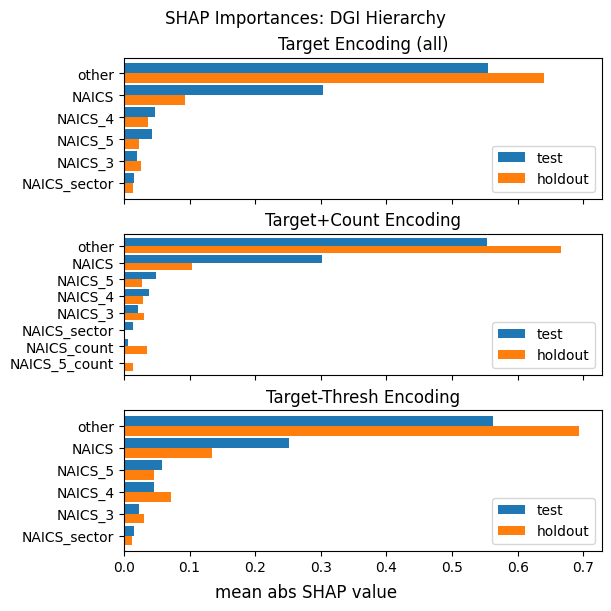

In [107]:
models = ['menc_all', 'tc', 'tt']
fig, ax = plt.subplots(3, 1, sharex = True, sharey = False, figsize=(6, 6),
                      layout='constrained')
for i, model in enumerate(models):
    shap_import_bar_2color(import_all_test[import_all_test['model'] == model],
                       import_all_ho[import_all_ho['model'] == model],
                          ax=ax[i])
fig.suptitle('SHAP Importances: DGI Hierarchy')
fig.supxlabel('mean abs SHAP value')

## 3 Bar Plot
Show other features, main NAICS feature, and all other features as importance

In [114]:
def agg_enc_3way(data):
    data = data.copy()
    cond = [data['enc_flag'] == 0,
            data['variable'].isin(['NAICS_NAICS', 'NAICS_response','mhier_NAICS_alt', 'menc_NAICS',
                                  'NAICS', 'mhier_NAICS', 'tt_NAICS'])]
    choice = ['Other Features', 'NAICS-Primary',]
    cat_type= pd.CategoricalDtype(categories = ['Other Features', 'NAICS-Primary', 'NAICS-Hier/Other'],
                                 ordered=True)
    data['type'] = pd.Series(np.select(cond, choice, 'NAICS-Hier/Other')).astype(cat_type)
    data_1 = data \
        .groupby(['model', 'type', 'index']) \
        ['value'] \
        .agg('sum') \
        .reset_index(level=[0,1])
    data_1['value_abs'] = np.abs(data_1['value'])
    data_2 = data_1 \
        .groupby(['model', 'type']) \
        [['value_abs', 'value']] \
        .agg('mean') \
        .reset_index()
    return data_2

In [115]:
enc_way_test = agg_enc_3way(shap_all_long_test)
enc_way_test

,model,type,value_abs,value
0,menc,Other Features,0.554551,-0.143952
1,menc,NAICS-Primary,0.366625,-0.059871
2,menc,NAICS-Hier/Other,0.000000,0.000000
3,menc_all,Other Features,0.555496,-0.143553
4,menc_all,NAICS-Primary,0.302684,-0.049849
5,menc_all,NAICS-Hier/Other,0.094144,-0.010697
6,mhier,Other Features,0.548655,-0.142541
7,mhier,NAICS-Primary,0.366027,-0.063126
8,mhier,NAICS-Hier/Other,0.000000,0.000000
9,tc,Other Features,0.553378,-0.142560


In [116]:
enc_way_ho =  agg_enc_3way(shap_all_long_ho)
enc_way_ho

,model,type,value_abs,value
0,menc,Other Features,0.648219,-0.259119
1,menc,NAICS-Primary,0.093835,0.093832
2,menc,NAICS-Hier/Other,0.000000,0.000000
3,menc_all,Other Features,0.640744,-0.255134
4,menc_all,NAICS-Primary,0.093559,0.093554
5,menc_all,NAICS-Hier/Other,0.058392,-0.028270
6,mhier,Other Features,0.612161,-0.231707
7,mhier,NAICS-Primary,0.342198,-0.063008
8,mhier,NAICS-Hier/Other,0.000000,0.000000
9,tc,Other Features,0.665498,-0.265534


In [190]:
enc_way_test.to_csv(Path(setup.temp_path).joinpath('A40_DATA_shap_three_grp_test.csv'))
enc_way_ho.to_csv(Path(setup.temp_path).joinpath('A40_DATA_shap_three_grp_ho.csv'))

In [183]:
# Function to do bar plot
def shap_3way_bar(data, values = 'value_abs',
                      title = None, xlabel = None, ax = None,
                 figsize = None):
    
    # Label models
    data = data.copy()
    data['model_label']  = setup.label_models(data)

    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 3))
    data_pivot = data.pivot(index='model_label', columns='type', values=values) \
        .reset_index()
    data_pivot['model_label'] = data_pivot['model_label'].astype(setup.model_label_type)
    data_pivot.sort_values('model_label').set_index('model_label') \
        .plot(kind='barh', ax=ax, width=0.7, figsize=figsize)
    ax.invert_yaxis()
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    #ax.legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=2)

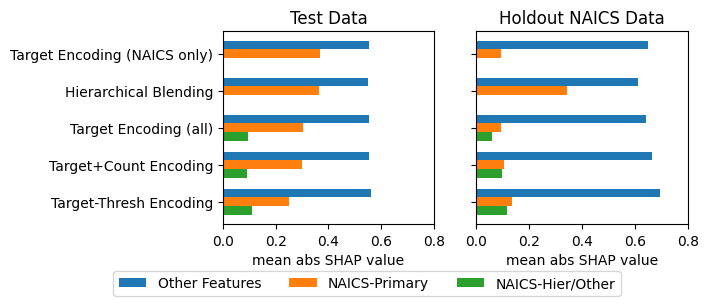

In [184]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(6, 2.5))
shap_3way_bar(enc_way_test, 'value_abs', ax=ax[0], title='Test Data',
                     xlabel='mean abs SHAP value')
shap_3way_bar(enc_way_ho, 'value_abs', ax=ax[1], title='Holdout NAICS Data',
                     xlabel='mean abs SHAP value')
ax[0].get_legend().remove()
ax[0].set_xlim(0, 0.8)
ax[1].set_xlim(0, 0.8)
ax[1].legend(bbox_to_anchor=(0.8, -0.05),  bbox_transform=fig.transFigure, ncol=3)
fig.savefig(Path(setup.temp_path).joinpath('A40_PLOT_enc_type_3bar.png'),
        bbox_inches='tight')

## Smaller plots (blog format)

##### Separate standard target encoding

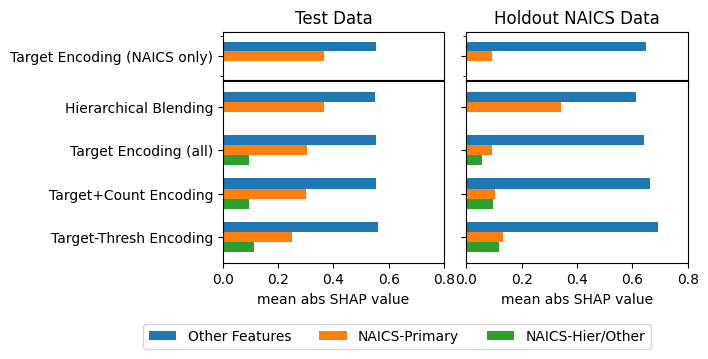

In [188]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = 'row',
                       gridspec_kw={'height_ratios': [1, 3.8]},
                      figsize=(6,3))

# Only target encoding
shap_3way_bar(enc_way_test[enc_way_test['model'] == 'menc'], 
              'value_abs', ax=ax[0, 0], title='Test Data', xlabel='mean abs SHAP value')
shap_3way_bar(enc_way_ho[enc_way_ho['model'] == 'menc'], 
              'value_abs', ax=ax[0, 1],  title='Holdout NAICS Data',
                     xlabel='mean abs SHAP value')
# All but target encoding
shap_3way_bar(enc_way_test[enc_way_test['model'] != 'menc'], 
              'value_abs', ax=ax[1, 0],xlabel='mean abs SHAP value')
shap_3way_bar(enc_way_ho[enc_way_ho['model'] != 'menc'], 
              'value_abs', ax=ax[1, 1],
                     xlabel='mean abs SHAP value')
[a.get_legend().remove() for al in ax for a in al ]
[a.set_xlim(0, 0.8) for al in ax for a in al ]
ax[1,1].legend(bbox_to_anchor=(0.85, -0.07),  bbox_transform=fig.transFigure, ncol=3)
fig.set_figwidth(6)
plt.subplots_adjust(hspace=0.01, wspace=0.1)
fig.savefig(Path(setup.temp_path).joinpath('A40_PLOT_3bar_condensed.png'),
        bbox_inches='tight')